## Half and Half
This notebook is the Python implementation of this awesomely simple R code: https://www.kaggle.com/kailex/ac-dc by [kxx](https://www.kaggle.com/kailex)

It demonstrates splitting the data in half and using each half to build a model which performs very well on the public LB with minimal feature engineering. The discussion on the same: https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115851

In [1]:
from sklearn.model_selection import train_test_split, KFold

from hyperopt import hp
from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import hyperopt.pyll
from hyperopt.pyll import scope

import warnings
warnings.simplefilter('ignore')

In [2]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import KernelPCA, PCA

path_data = "data/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

## Reading train data
Reading train data along with building and weather metadata.

In [3]:
df_train = pd.read_csv(path_train)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)

In [4]:
df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

In [5]:
#df_train = df_train.median().astype(np.float16)
#df_train['building_median'] = df_train['building_id'].map(building_median)

In [6]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df_train = reduce_mem_usage(df_train, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 757.98 MB
Memory usage after optimization is: 322.52 MB
Decreased by 57.4%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 72.6%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


## Preparing data
There are two files with features that need to be merged with the data. One is building metadata that has information on the buildings and the other is weather data that has information on the weather.   

Note that the only features created are hour, weekday and is_holiday!

In [8]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [ ]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]

In [ ]:
def prepare_timestamp(X, holidays):
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    X["is_holiday"] = X[["is_holiday", "weekday"]].apply(lambda x: 1 if x['is_holiday'] == 1 or x['weekday'] in (5, 6) else 0, axis=1)
       
    #drop_features = ["timestamp",]
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)
    gc.collect()
    return X

In [9]:
X_train, y_train = prepare_data(df_train, building, weather_train)
X_train = prepare_data(X_train, holidays)

del df_train, weather_train
gc.collect()

NameError: name 'drop_features' is not defined

In [ ]:
X_train.head()

In [17]:
PCA_features = ["sea_level_pressure", "wind_direction", "wind_speed"]
scaler = StandardScaler()
scaler.fit(X_train[PCA_features].fillna(0))
pca_scaled_train = scaler.transform(X_train[PCA_features].fillna(0))
#pca = KernelPCA(n_components=1, kernel='poly', n_jobs=-1)
pca = PCA(n_components=1)
pca.fit(pca_scaled_train)
X_train['pca_fet'] = pca.transform(pca_scaled_train)
X_train.drop(PCA_features, axis=1, inplace=True)

## Two-fold LightGBM Model split half-and-half
The data is split into two based on time. Each half is used as the training data for a model.

**Half 1:** The first 50% rows of train data   
**Half 2:** The last 50% rows of train data

In [18]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

cat = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=cat, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=cat, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 45,
    "learning_rate": 0.055,
    "feature_fraction": 0.8,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1200, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1200, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.871236	valid_1's rmse: 1.14431
[400]	training's rmse: 0.824784	valid_1's rmse: 1.13874
[600]	training's rmse: 0.803417	valid_1's rmse: 1.137
[800]	training's rmse: 0.781466	valid_1's rmse: 1.13803
Early stopping, best iteration is:
[622]	training's rmse: 0.800507	valid_1's rmse: 1.13652
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.888524	valid_1's rmse: 1.15284
[400]	training's rmse: 0.843645	valid_1's rmse: 1.14677
[600]	training's rmse: 0.821549	valid_1's rmse: 1.14653
Early stopping, best iteration is:
[524]	training's rmse: 0.830506	valid_1's rmse: 1.14603


In [11]:
%%time

# Чем больше P, тем меньше мы хотим штрафовать за разницу между train  и test
p = 0.8
# k - количество итераций
k = 50

skf = KFold(n_splits=3, shuffle=True, random_state=7)

def score(params):
    print('Training with params:')
    print(params)
    w=[]
    best_iter = []
    

    for train_index, val_index in skf.split(X_half_1, y_half_1):
        x_train_1, x_valid_1 = X_half_1.iloc[train_index, :], X_half_1.iloc[val_index, :]
        y_train_1, y_valid_1 = y_half_1.iloc[train_index], y_half_1.iloc[val_index]
        train_data = lgb.Dataset(x_train_1, label=y_train_1, categorical_feature=cat)
        val_data = lgb.Dataset(x_valid_1, label=y_valid_1, categorical_feature=cat, reference=train_data)
        gbm = lgb.train(params,
                        train_data,
                        valid_sets = [train_data, val_data],
                        valid_names=['train', 'val'],
                        num_boost_round = 2000,
                        verbose_eval = False, 
                        categorical_feature=cat
                       )
        w.append([gbm.best_score['train']['rmse'], gbm.best_score['val']['rmse']])
        best_iter.append(gbm.best_iteration)
    nrounds = np.mean(best_iter)
    print('best iter:', int(nrounds), 'all iter:', best_iter)
    res = list(np.mean(w, axis=0))
    print("\t auc train {0}, auc test {1}, dif {2}, \n\t final score {3} \n\n".format(res[0], res[1], np.power(np.square(res[0]-res[1]), p), +res[1]+np.power(np.square(res[0]-res[1]), p)))
    return {'loss': +res[1]+np.power(np.square(res[0]-res[1]), p), 'status': STATUS_OK, 
            'mean_auc_train': res[0], 'mean_auc_test': res[1], 'best_iter': int(nrounds)}

def optimize(trials):
    space = {
        #'max_depth': hp.choice('max_depth', [-1, 6, 7]),
        'max_depth': -1,
        'num_leaves': scope.int(hp.uniform('num_leaves', 20, 100)),
        'lambda_l1': hp.quniform('lambda_l1', 0, 4, 0.25),
        'lambda_l2': hp.quniform('lambda_l2', 0, 8, 0.25),
        'learning_rate': hp.quniform('learning_rate', 0.04 , 0.06, 0.005),
        'feature_fraction': hp.quniform('feature_fraction', 0.3, 0.9, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.3, 0.9, 0.1),
        'metric': ('rmse',),
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': 8,
        'early_stopping_rounds': 10,
        'silent':1,
    }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=k)
    print(best)

trials = Trials()
optimize(trials)

Training with params:                                                          
{'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.8, 'lambda_l1': 2.75, 'lambda_l2': 5.25, 'learning_rate': 0.045, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 62, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.7332333446061745, auc test 0.7444556017784256, dif 0.000758801790547569, 
	 final score 0.7452144035689732 


Training with params:                                                          
{'bagging_fraction': 0.9, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.6000000000000001,

{'bagging_fraction': 0.30000000000000004, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 4.0, 'lambda_l2': 6.0, 'learning_rate': 0.055, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 99, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.6836167146589975, auc test 0.7041561135562618, dif 0.0019959073024541554, 
	 final score 0.706152020858716 


Training with params:                                                          
{'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 4.0, 'lambda_l2': 6.0, 'learning_rate': 0.055, 'max_depth': -1, 'me

{'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 3.5, 'lambda_l2': 0.25, 'learning_rate': 0.06, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 84, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.6856217632162651, auc test 0.7059599049653786, dif 0.0019647080826380803, 
	 final score 0.7079246130480167 


Training with params:                                                          
{'bagging_fraction': 0.7000000000000001, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 2.5, 'lambda_l2': 7.0, 'learning_rate': 0.05, 'max_d

In [12]:
%%time

# Чем больше P, тем меньше мы хотим штрафовать за разницу между train  и test
p = 0.8
# k - количество итераций
k = 50

skf = KFold(n_splits=3, shuffle=True, random_state=7)

def score(params):
    print('Training with params:')
    print(params)
    w=[]
    best_iter = []
    

    for train_index, val_index in skf.split(X_half_2, y_half_2):
        x_train_1, x_valid_1 = X_half_2.iloc[train_index, :], X_half_2.iloc[val_index, :]
        y_train_1, y_valid_1 = y_half_2.iloc[train_index], y_half_2.iloc[val_index]
        train_data = lgb.Dataset(x_train_1, label=y_train_1, categorical_feature=cat)
        val_data = lgb.Dataset(x_valid_1, label=y_valid_1, categorical_feature=cat, reference=train_data)
        gbm = lgb.train(params,
                        train_data,
                        valid_sets = [train_data, val_data],
                        valid_names=['train', 'val'],
                        num_boost_round = 2000,
                        verbose_eval = False, 
                        categorical_feature=cat
                       )
        w.append([gbm.best_score['train']['rmse'], gbm.best_score['val']['rmse']])
        best_iter.append(gbm.best_iteration)
    nrounds = np.mean(best_iter)
    print('best iter:', int(nrounds), 'all iter:', best_iter)
    res = list(np.mean(w, axis=0))
    print("\t auc train {0}, auc test {1}, dif {2}, \n\t final score {3} \n\n".format(res[0], res[1], np.power(np.square(res[0]-res[1]), p), +res[1]+np.power(np.square(res[0]-res[1]), p)))
    return {'loss': +res[1]+np.power(np.square(res[0]-res[1]), p), 'status': STATUS_OK, 
            'mean_auc_train': res[0], 'mean_auc_test': res[1], 'best_iter': int(nrounds)}

def optimize(trials):
    space = {
        #'max_depth': hp.choice('max_depth', [-1, 6, 7]),
        'max_depth': -1,
        'num_leaves': scope.int(hp.uniform('num_leaves', 20, 100)),
        'lambda_l1': hp.quniform('lambda_l1', 0, 4, 0.25),
        'lambda_l2': hp.quniform('lambda_l2', 0, 8, 0.25),
        'learning_rate': hp.quniform('learning_rate', 0.04 , 0.06, 0.005),
        'feature_fraction': hp.quniform('feature_fraction', 0.3, 0.9, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.3, 0.9, 0.1),
        'metric': ('rmse',),
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': 8,
        'early_stopping_rounds': 10,
        'silent':1,
    }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=k)
    print(best)

trials = Trials()
optimize(trials)

Training with params:                                                          
{'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.4, 'lambda_l1': 2.25, 'lambda_l2': 4.0, 'learning_rate': 0.05, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 79, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.8011899758492532, auc test 0.8083020038241756, dif 0.0003657543752701834, 
	 final score 0.8086677581994458 


Training with params:                                                          
{'bagging_fraction': 0.4, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.4, 'lambda_l1': 3.

Training with params:                                                          
{'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 0.0, 'lambda_l2': 7.5, 'learning_rate': 0.04, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 99, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.7073730740047582, auc test 0.7253227448127514, dif 0.0016087567459665345, 
	 final score 0.7269315015587179 


Training with params:                                                          
{'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 1.7

{'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.9, 'lambda_l1': 0.5, 'lambda_l2': 5.0, 'learning_rate': 0.045, 'max_depth': -1, 'metric': ('rmse',), 'nthread': 8, 'num_leaves': 60, 'objective': 'regression', 'silent': 1}
best iter:                                                                     
2000                                                                           
all iter:                                                                      
[2000, 2000, 2000]                                                             
	 auc train 0.731615149232475, auc test 0.7445369859698023, dif 0.0009508648629723891, 
	 final score 0.7454878508327747 


Training with params:                                                          
{'bagging_fraction': 0.7000000000000001, 'boosting_type': 'gbdt', 'early_stopping_rounds': 10, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 2.75, 'lambda_l2': 4.5, 'learning_rate': 0.04, 'max_d

## Feature Importance
Plotting the feature importance from LGBM.

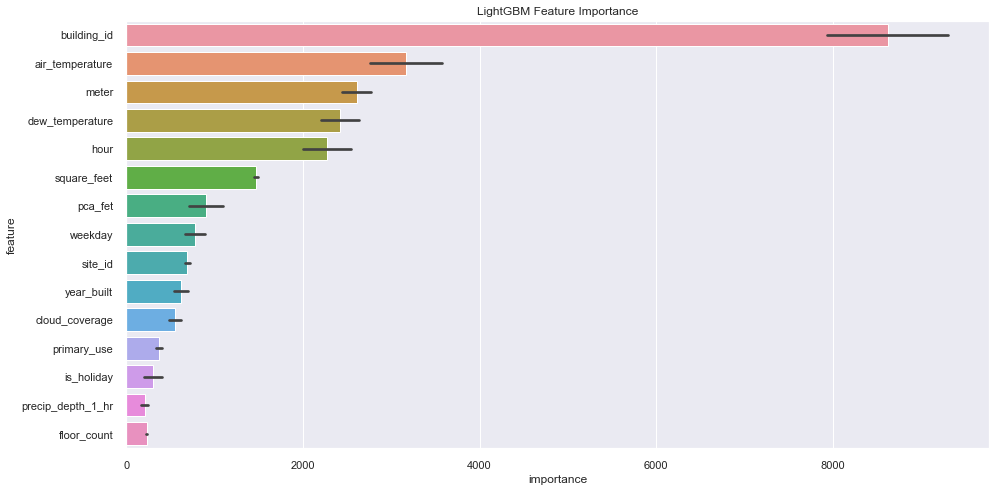

In [19]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [20]:
del X_train, y_train, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, df_fimp_1, df_fimp_2, df_fimp
gc.collect()

4660

## Preparing test data
Preparing test data with same features as train data.

In [21]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 8.96 MB
Decreased by 53.0%


In [22]:
#X_test['building_median'] = X_test['building_id'].map(building_median)

In [23]:
X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

In [24]:
pca_scaled_test = scaler.transform(X_test[PCA_features].fillna(0))
X_test['pca_fet'] = pca.transform(pca_scaled_test)
X_test.drop(PCA_features, axis=1, inplace=True)

In [25]:
del df_test, building, weather_test
gc.collect()

118

## Scoring test data
Averaging predictions from the two half train data models.

In [26]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

12

## Submission
Preparing final file for submission.

In [27]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("sub_v4.csv", index=False)

**P.S.** If you vote up this kernel, please don't forget to vote up the original R version: https://www.kaggle.com/kailex/ac-dc

If you're interested in trying out site specific models, check out my [Divide and Conquer notebook](https://www.kaggle.com/rohanrao/ashrae-divide-and-conquer/output).